In [56]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sp
import h5py as hp  
import os 
import pandas as pd
import re
import utility
import matplotlib.patches as patches

current_directory= os.getcwd()
directory = r"{}".format(current_directory)
#=============================================
# Lens parameters
#=============================================
FocalLength = 100
LensDiameter= 20
PeriodUnitCell = 0.4 
Wavelength = 1.55
zemax_phase_file_name=  'optimized_phase_zemax_d_20_fl_100.txt'
unit_cell_library_file_name= 'EH_and_phase_vs_radius_interp_fdtd_si_sio2_sept13.mat'
Optimize= 1 # 1 for optimized phase through Zemax and 0 for ideal hyperbolic


#### Read the Zemax Optimized Phase file and store the information

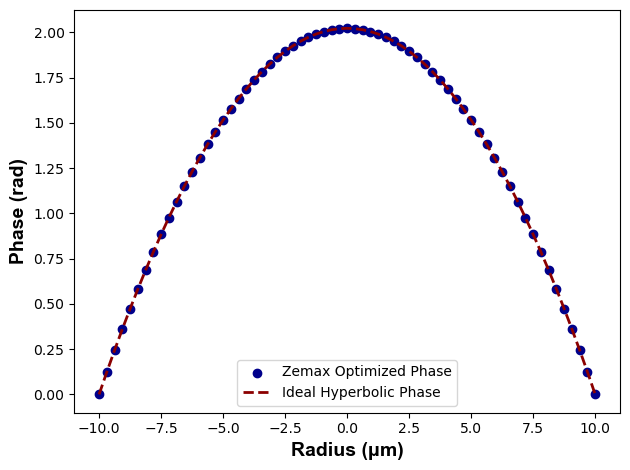

In [57]:
#=============================================
# read the optimized phase from Zemax 
#=============================================
LensRadius= LensDiameter/2.0
filename = directory +'\\'+ zemax_phase_file_name
x_zemax, y_zemax, phase_zemax= utility.read_zemax_phase(filename) 

#======================================
# Alternative way to read zemax file
#======================================
# Optionally, store the lists into variables for later use or save them in a file
#optimized_phase= read_csv_with_pandas(zemax_result_file)

# the x of zemax comes in mm 
x_zemax= np.array([i* 1e3 for i in x_zemax])
phase_zemax= (2*np.pi)*np.array([i for i in phase_zemax])
phase_zemax= phase_zemax- min(phase_zemax)
#phase_zemax= np.mod(phase_zemax, 2* np.pi)

phase_hyperbolic = -(2*np.pi/Wavelength)*(np.sqrt(x_zemax**2+FocalLength**2)-FocalLength) # Hyperbolic lens is assumed with mod 2pi phase target
#phase_hyperbolic= -np.mod(phase_hyperbolic, 2* np.pi)
phase_hyperbolic= phase_hyperbolic- min(phase_hyperbolic)


plt.scatter(x_zemax, phase_zemax, color= 'darkblue',label= 'Zemax Optimized Phase')
plt.plot(x_zemax, phase_hyperbolic,linestyle= '--',color='darkred', label= 'Ideal Hyperbolic Phase', linewidth= 2.0)
plt.ylabel('Phase (rad)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
plt.xlabel('Radius (μm)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
#plt.ylim(0,2* np.pi)
plt.legend()
plt.tight_layout()
plt.show()


#### Collect the information of the metaatom library 

In [58]:
file = directory+ '\\2_meta_library\\unit cell'+'\\' + unit_cell_library_file_name

f = hp.File(file,'r')
list(f.keys())

rad= f['radius'][:]
phase= f['phase'][:]  
f.close
rad=rad[0]*1e6 # adjusted for unit conversion
phase= phase[0]

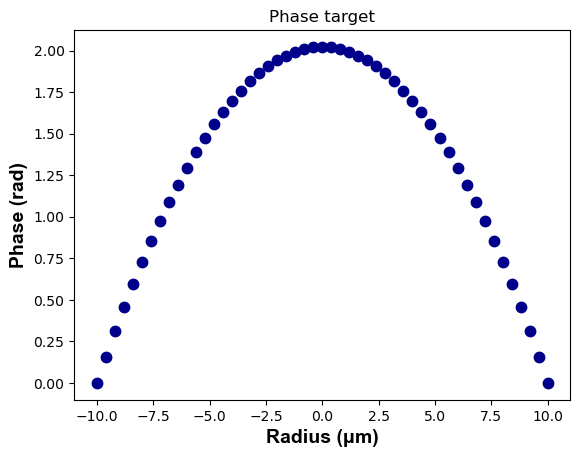

In [59]:
# this file was written to visualize the meta-atom placement 
NumMetaAtom = round(LensRadius/PeriodUnitCell)

x_mask = PeriodUnitCell* np.arange(-NumMetaAtom, NumMetaAtom+1)
y_mask = PeriodUnitCell* np.arange(-NumMetaAtom, NumMetaAtom+1)

#print(x_mask)
if Optimize == 0:
    phase_target = -np.mod((2*np.pi/Wavelength)*(np.sqrt(x_mask**2+FocalLength**2)-FocalLength),2*np.pi) # Hyperbolic lens is assumed with mod 2pi phase target
    phase_target  = phase_target  - min(phase_target )
elif Optimize == 1:
    phase_target= utility.create_phase_target(phase_zemax, x_zemax, x_mask)

phase_target= np.mod(phase_target, 2* np.pi)

#===========================
plt.scatter(x_mask,phase_target, color = 'darkblue', linewidth= 2.5)
plt.ylabel('Phase (rad)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
plt.xlabel('Radius (μm)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
plt.title('Phase target')
plt.show()
#===========================
#file = 'C:\\Users\\DebanikDas\\Desktop\\ApexResearch\\MetalensLumerical\\MetalensBenchmark\\3 Debanik Full Lens\\full_lens_python_files\\EH_and_phase_vs_radius_interp_fdtd_si_sio2_sept11.mat'

#print(rad)

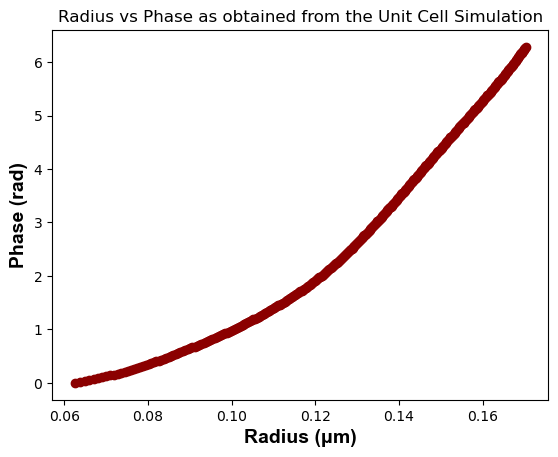

In [60]:
# Step 3: Obtain the radius vs. position yielding the desired phase profile

# Create the interpolation function (linear by default)
interp_func = sp.interpolate.interp1d(phase, rad, kind='cubic')

# Interpolate to find corresponding 'rad' values for 'phase_target'
radius_mask = interp_func(phase_target)

plt.figure()
plt.scatter(rad, phase, color = 'darkred')
plt.title('Radius vs Phase as obtained from the Unit Cell Simulation')
plt.xlabel('Radius (μm)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
plt.ylabel('Phase (rad)', fontdict={'size': 14, 'weight': 'bold', 'font': 'arial'})
plt.show()

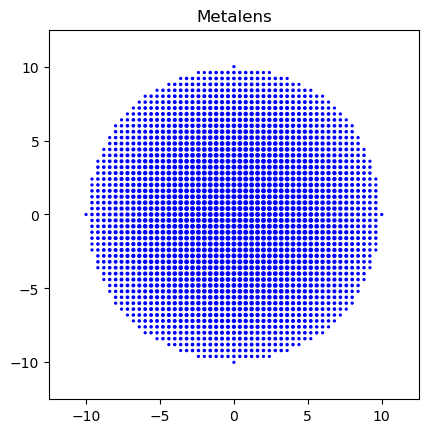

In [61]:

# Create a new figure
plt.figure()

# Get the current axis
ax = plt.gca()
x_y_rad= []

# Loop over x_mask and y_mask to compute r and add circles where r <= LensRadius
for i, x in enumerate(x_mask):
    for j, y in enumerate(y_mask):
        r = np.sqrt(x**2 + y**2)
       # print(r)
        if r <= LensRadius:
            # Find the index where x_mask is close to the radius r
            # (use np.abs to handle floating point precision)
            idx = np.where(np.abs(x_mask - r) <= 0.2)[0]
            if idx.size > 0:  # If index found
                pillar_rad=  radius_mask[idx[0]]
                circle = patches.Circle((x, y), pillar_rad, color='b', fill=True)
                x_y_rad.append({'x': x, 'y': y, 'radius': pillar_rad})
                ax.add_patch(circle)
            
            
           

# Set axis limits to match the range of x_mask and y_mask
delta= LensRadius/4
ax.set_xlim(min(x_mask)-delta, max(x_mask)+ delta)
ax.set_ylim(min(y_mask)-delta, max(y_mask)+ delta)

# Equal aspect ratio for correct circle appearance
ax.set_aspect('equal')
plt.title('Metalens')

# Display the plot
plt.show()

In [62]:
x_python= np.array([elem['x']*1e-6 for elem in x_y_rad])
y_python= np.array([elem['y']*1e-6 for elem in x_y_rad])
rad_python= np.array([elem['radius']*1e-6 for elem in x_y_rad])

# Stack arrays column-wise
data = np.column_stack((x_python, y_python, rad_python))

# Save to CSV
if Optimize== 1:
    fname= '_optimized'
elif Optimize ==0:
    fname= '_NOT_optimized'
    
np.savetxt('output_x_y_rad_apexPHAZE'+ fname+ '.txt', data, delimiter=",")

In [69]:
# import math

# # Given data
# wavelength = 55e-9  # wavelength in meters (532 nm)
# efl = 1e-3  # Effective Focal Length (EFL) in meters (2 mm)
# f_number = 2  # F-number
# n = 1.0  # refractive index

# # Airy disk radius calculation (diffraction limited spot size)
# # Formula: r_Airy = 1.22 * (lambda / (n * 2 * F#)) * EFL
# r_airy = 1.22 * (wavelength / (n * 2 * f_number)) * efl

# # RMS spot size (typically, RMS spot size is approximately 1/2.44 of the Airy disk diameter)
# # RMS spot size = Airy disk radius / sqrt(2)
# rms_spot_size = r_airy / math.sqrt(2)

# r_airy* 1e6, rms_spot_size* 1e6


6.71